In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['test', 'train', 'train.csv', 'sample_submission.csv']


In [2]:
from tqdm import tqdm, tqdm_notebook
import cv2
import seaborn as sns

In [3]:
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.initializers import glorot_uniform
from keras import optimizers

Using TensorFlow backend.


# imge pretreatment

In [4]:
train_path = '../input/train/train/'
test_path = "../input/test/test/"
train_csv = pd.read_csv('../input/train.csv')

In [5]:
labels = []
images = []
image_name = train_csv['id'].values
for img_id in tqdm_notebook(image_name):
    imdata = cv2.imread(train_path + img_id)
    images.append(imdata)
    has_cactus = train_csv[train_csv['id'] == img_id]['has_cactus'].values
    labels.append(has_cactus)

In [6]:
images = np.asarray(images)
images = images.astype('float32')
images /= 255
labels = np.asarray(labels)

In [7]:
images.shape, labels.shape

((17500, 32, 32, 3), (17500, 1))

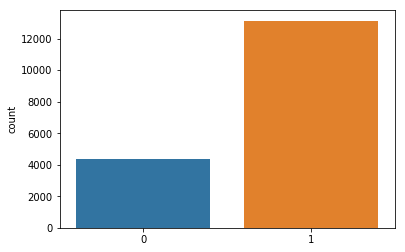

In [8]:
sns.countplot(np.squeeze(labels))

# 构建模型

In [9]:
# GRADED FUNCTION: identity_block

def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1, 1), padding = "same", name = conv_name_base + "2b", kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + "2b")(X)
    X = Activation("relu")(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1, 1), padding = "valid", name = conv_name_base + "2c", kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + "2c")(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation("relu")(X)
    
    ### END CODE HERE ###
    
    return X

In [10]:
# GRADED FUNCTION: convolutional_block

def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = Conv2D(F2, (f, f), strides = (1, 1), name = conv_name_base + "2b", kernel_initializer = glorot_uniform(seed=0), padding = "same")(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + "2b")(X)
    X = Activation("relu")(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(F3, (1, 1), strides = (1, 1), name = conv_name_base + "2c", kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + "2c")(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(F3, (1, 1), strides = (s, s), name = conv_name_base + "1", kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + "1")(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation("relu")(X)
    
    ### END CODE HERE ###
    
    return X

In [11]:
# GRADED FUNCTION: ResNet50

def ResNet50(input_shape = (32, 32, 3), classes = 1):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(32, (7, 7), strides = (2, 2), name = 'conv1', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = 'bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [32, 32, 256], stage = 2, block='a', s = 1)
    X = identity_block(X, 3, [32, 32, 256], stage=2, block='b')
    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [64, 64, 512], stage = 3, block = "a", s = 2)
    X = identity_block(X, f = 3, filters = [64, 64, 512], stage = 3, block = "b")

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 1024], stage = 4, block = "a", s = 2)
    X = identity_block(X, f = 3, filters = [128, 128, 1024], stage = 4, block = "b")

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 2048], stage = 5, block = "a", s = 2)
    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    #X = AveragePooling2D((2, 2), name = "ave_pool")(X)
    
    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [12]:
model = ResNet50()

In [13]:
#model
from keras import models
model = models.Sequential() 

model.add(layers.Conv2D(32, (3, 3), activation='relu',                     
                                    input_shape=(32, 32, 3))) 
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2))) 

 
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten()) 
model.add(layers.Dense(512, activation='relu')) 
model.add(layers.Dense(1, activation='sigmoid'))

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1600)              0         
__________

# 开始预测

In [15]:
model.compile(loss='binary_crossentropy',      
              optimizer=optimizers.RMSprop(lr=1e-4),         
              metrics=['acc'])

In [16]:
hist = model.fit(images, labels,
                validation_split=0.2,
                batch_size=100,
                epochs = 20,
                )

Train on 14000 samples, validate on 3500 samples
Epoch 1/20
14000/14000 [==============================] - 4s 316us/step - loss: 0.3205 - acc: 0.8562 - val_loss: 0.2419 - val_acc: 0.9023
Epoch 2/20
14000/14000 [==============================] - 1s 74us/step - loss: 0.1864 - acc: 0.9275 - val_loss: 0.1531 - val_acc: 0.9431
Epoch 3/20
14000/14000 [==============================] - 1s 74us/step - loss: 0.1672 - acc: 0.9336 - val_loss: 0.1459 - val_acc: 0.9429
Epoch 4/20
14000/14000 [==============================] - 1s 74us/step - loss: 0.1520 - acc: 0.9414 - val_loss: 0.1198 - val_acc: 0.9563
Epoch 5/20
14000/14000 [==============================] - 1s 74us/step - loss: 0.1383 - acc: 0.9474 - val_loss: 0.1515 - val_acc: 0.9437
Epoch 6/20
14000/14000 [==============================] - 1s 75us/step - loss: 0.1271 - acc: 0.9528 - val_loss: 0.1026 - val_acc: 0.9649
Epoch 7/20
14000/14000 [==============================] - 1s 74us/step - loss: 0.1176 - acc: 0.9560 - val_loss: 0.1102 - val_acc

In [17]:
hist.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

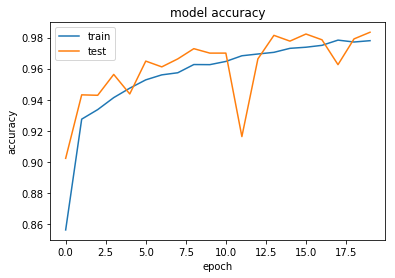

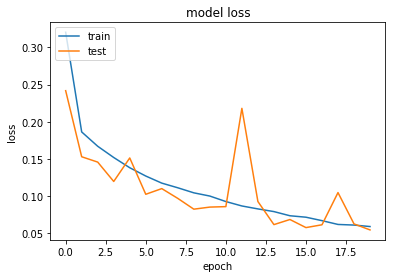

In [18]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
test = []
test_id = []
for img_id in tqdm_notebook(os.listdir(test_path)):
    test.append(cv2.imread(test_path + img_id))     
    test_id.append(img_id)
test = np.asarray(test)
test = test.astype('float32')
test /= 255

In [20]:
test_predictions = model.predict(test)

In [21]:
sub_df = pd.DataFrame(test_predictions, columns=['has_cactus'])
sub_df['has_cactus'] = sub_df['has_cactus'].apply(lambda x: 1 if x > 0.75 else 0)
sub_df['id'] = ''
cols = sub_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
sub_df=sub_df[cols]
for i, img in enumerate(test_id):
    sub_df.set_value(i,'id',img)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


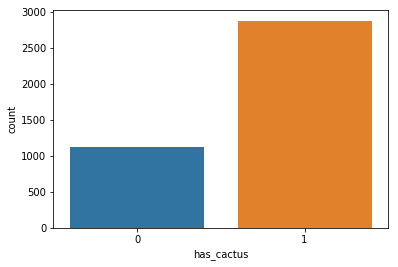

In [22]:
sns.countplot(sub_df['has_cactus'])

In [23]:
sub_df.to_csv('submission.csv',index=False)